# Track the Voids
Determine which voids in each image are the same and save the trajectories

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.analysis import convert_to_per_particle, compile_void_tracks
from pathlib import Path
import trackpy as tp
import pandas as pd
import numpy as np

Configuration

In [2]:
run_directory = '../../../learning-defect-pde/data/8bitTIFF-video32-625C/'

In [3]:
run_directory = Path(run_directory)
run_name = run_directory.name
out_directory = Path('output') / run_name
defect_details = out_directory / 'defect-details.json'

## Load in the defect information
The `rtdefects` command-line application generates a JSON file with the positions and sizes of each void detected in each frame.

Our first step is to load that JSON into memory

In [4]:
void_data = pd.read_json(defect_details, lines=True)
void_data['frame'] = np.arange(len(void_data))
print(f'Loaded defects from {len(void_data)} frames')

Loaded defects from 860 frames


## Show that we've detected void growth
Without tracking individual voids, we can see that they are growing in size and number

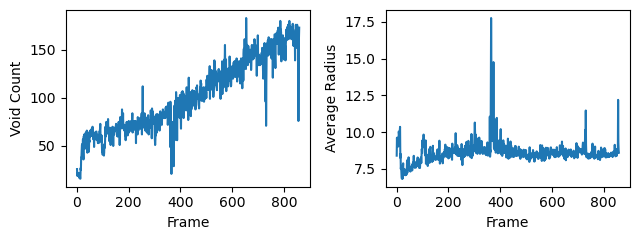

In [5]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(6.5, 2.5))

axs[0].plot(void_data.index, void_data['void_count'])
axs[0].set_ylabel('Void Count')

axs[1].plot(void_data.index, void_data['radii_average'])
axs[1].set_ylabel('Average Radius')

for ax in axs:
    ax.set_xlabel('Frame')
    
fig.tight_layout()

We can see that we are detecting at least a dozen void per frame. Both the number and size increase with time.

There are many frames at the end where we don't detect any defects. Let's eliminate thsoe from the analysis.

In [6]:
void_data.query('void_count > 0', inplace=True, )
print(f'Reduced to {len(void_data)} frames with at least 1 void.')

Reduced to 860 frames with at least 1 void.


## Identify High-Movement Regions
Regions where the voids move rapidly are problematic for tracking. Let's isolate these regions then ignore them in tracking

In [7]:
drift = np.array(void_data['drift'].tolist())
drift_between_frames = np.linalg.norm(np.diff(drift, axis=0), axis=1)

Text(0, 0.5, 'Between Frame Drift')

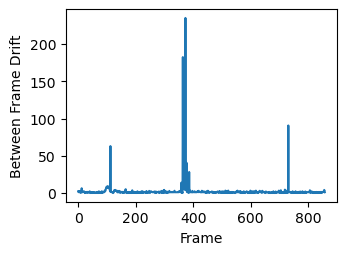

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(drift_between_frames)
ax.set_xlabel('Frame')
ax.set_ylabel('Between Frame Drift')

Exclude frames where the drift is above 10 per frame

In [9]:
void_data['unstable'] = False
void_data.iloc[1:, -1] = drift_between_frames > 15
print(f'{void_data["unstable"].sum()} of {len(void_data)} are unstable')

0 of 860 are unstable


Set bad frames known from manual inspection

In [10]:
void_data.loc[112, 'stable_frame'] = False

## Detect Tracks of Voids
This video already has drift canceled out, so we can determine the tracks with  relatively aggressive search range

In [11]:
%%time
particles = pd.concat(list(convert_to_per_particle(void_data, 'positions_corrected-fft', exclude_column='unstable')))
initial_tracks = tp.link_df(particles, search_range=16, memory=8)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles out of {void_data["void_count"].sum()} total')

Frame 859: 173 trajectories present.
Found a total of 5249 unique particles out of 87445 total
CPU times: user 1.88 s, sys: 152 ms, total: 2.04 s
Wall time: 1.91 s


Note how we fewer unique voids this time! Things that initially "moved" too far to detect because of the camera drift are now associated together.

In [12]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks.head()

,start_frame,end_frame,total_frames,inferred_frames,positions,touches_side,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,80,81,51,"[[85.7283950617, 56.2716049383], [88.118203022...","[False, False, False, False, False, False, Fal...","[0, 0, 0, 1, 0, 0, 1, 0, 0, None, None, None, ...","[0.0, 9.127754477746734, 16.86675035514744, 27...",34.650542,0.427784,"[0.0, 9.127754477746734, 16.9174369862938, 27....",211.672331,2.613239,"[5.0777062519, 5.4115163798, 5.3523723485, 5.5...",7.590395,4.513517,0.023396
1,0,0,1,0,"[[239.9805825243, 1009.3398058252]]",[True],[25],NaN,NaN,NaN,NaN,NaN,NaN,[5.7258989056],5.725899,5.725899,NaN
2,0,112,113,0,"[[843.0337837838, 972.7792792793], [846.456122...","[False, False, False, False, False, False, Fal...","[24, 18, 21, 21, 18, 21, 21, 19, 16, 17, 17, 1...","[0.0, 8.756604097215577, 17.517538135534547, 2...",34.521390,0.305499,"[0.0, 8.756604097215577, 17.519046142583292, 2...",966.423435,8.552420,"[11.8882122065, 12.1399125739, 12.047792665, 1...",14.527197,11.437892,0.020098
3,0,112,113,0,"[[315.4890219561, 954.6906187625], [318.749748...","[False, False, False, False, False, False, Fal...","[23, 17, 20, 20, 17, 20, 20, 18, 15, 16, 16, 1...","[0.0, 8.383755726931543, 16.958920696390567, 2...",34.149895,0.302211,"[0.0, 8.383755726931543, 16.96100945337527, 26...",961.501900,8.508866,"[12.6282719712, 12.7286971866, 12.7161874074, ...",16.351768,12.360774,0.036429
4,0,120,121,9,"[[696.404040404, 850.4747474747], [699.7703769...","[False, False, False, False, False, False, Fal...","[22, 15, 18, 18, 15, 18, 18, 17, 14, 15, 13, 1...","[0.0, 7.020307235307107, 16.096586494189353, 2...",33.368810,0.275775,"[0.0, 7.020307235307107, 16.096590931405927, 2...",952.742328,7.873904,"[5.6136154778, 5.4115163798, 5.5279063915, 5.3...",8.444016,4.406462,0.023343


Save the tracks

In [13]:
out_directory.mkdir(parents=True, exist_ok=True)
void_tracks.to_json(out_directory / f'tracks.json', orient='records', lines=True)

In [14]:
void_data.to_json(out_directory / f'defect-details.json', orient='records', lines=True)